In [43]:
import tensorflow as tf
import os, glob
import numpy as np
from astropy.constants import M_sun
from censai import PhysicalModel
from censai.data.cosmos import preprocess, decode
from censai.data import AugmentedTNGKappaGenerator
from censai.data.lenses_tng import encode_examples
from scipy.signal.windows import tukey
from datetime import datetime
import json
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.colors import LogNorm
from tqdm import tqdm

In [2]:
kappa_dir = os.getenv("CENSAI_PATH") + "/data/hkappa612_TNG100_512"
image_fov = 17.8
min_theta_e = 5
max_theta_e = 9
z_lens = 0.44
z_source = 2.4
crop = 50
max_shift = 0
rotate_by = "90"
rescaling_size = 100
bins = 10
cosmos_dir = os.getenv("CENSAI_PATH") + "/data/cosmos_23.5_preprocessed_highSNR_verydiffuse"
buffer_size = 1000
batch = 1
tukey_alpha = 0
shuffle_cosmos = True
src_pixels = 128
psf_sigma = 0.04
lens_pixels = 1024
noise_rms = 0.05
source_fov = 6


kappa_files = glob.glob(os.path.join(kappa_dir, "*.fits"))
if os.path.exists(os.path.join(kappa_dir, "good_kappa.txt")):  # filter out bad data (see validate_kappa_maps script)
    good_kappa = np.loadtxt(os.path.join(kappa_dir, "good_kappa.txt"))
    kappa_ids = [int(os.path.split(kap)[-1].split("_")[1]) for kap in kappa_files]
    keep_kappa = [kap_id in good_kappa for kap_id in kappa_ids]
    kappa_files = [kap_file for i, kap_file in enumerate(kappa_files) if keep_kappa[i]]

min_theta_e = 0.05 * image_fov if min_theta_e is None else min_theta_e
max_theta_e = 0.35 * image_fov if max_theta_e is None else max_theta_e
kappa_gen = AugmentedTNGKappaGenerator(
    kappa_fits_files=kappa_files,
    z_lens=z_lens,
    z_source=z_source,
    crop=crop,
    max_shift=max_shift,
    rotate_by=rotate_by,
    min_theta_e=min_theta_e,
    max_theta_e=max_theta_e,
    rescaling_size=rescaling_size,
    rescaling_theta_bins=bins
)
cosmos_files = glob.glob(os.path.join(cosmos_dir, "*.tfrecords"))
cosmos = tf.data.TFRecordDataset(cosmos_files)
n_galaxies = 0
for _ in cosmos:  # count the number of samples in the dataset
    n_galaxies += 1
cosmos = cosmos.map(decode).map(preprocess)
if shuffle_cosmos:
    cosmos = cosmos.shuffle(buffer_size=buffer_size)
cosmos = cosmos.batch(batch)

window = tukey(src_pixels, alpha=tukey_alpha)
window = np.outer(window, window)
phys = PhysicalModel(
    psf_sigma=psf_sigma,
    image_fov=kappa_gen.kappa_fov,
    src_fov=source_fov,
    pixels=lens_pixels,
    kappa_pixels=kappa_gen.crop_pixels,
    src_pixels=src_pixels,
    kappa_fov=kappa_gen.kappa_fov,
    method="conv2d"
)

In [23]:
# batch_index = np.random.randint(0, n_galaxies//batch)
# for galaxies, psf, ps in cosmos.skip(batch_index):  # only way to take the first batch is to fake a for loop
#     break
# galaxies = window[np.newaxis, ..., np.newaxis] * galaxies

# batch_size = galaxies.shape[0]
# kappa, einstein_radius, rescaling_factors, kappa_ids, einstein_radius_init = kappa_gen.draw_batch(
#     batch_size, rescale=True, shift=bool(max_shift), rotate=True, random_draw=True, return_einstein_radius_init=True)
# lens = []
# for b in range(batch_size):
#     lensed_images = phys.noisy_forward(tf.tile(galaxies[b][None, ...], [5, 1, 1, 1]), kappa, noise_rms=noise_rms)
#     lensed_images = tf.nn.relu(lensed_images)  # remove negative pixels
#     lensed_images /= tf.reduce_max(lensed_images, keepdims=True)
#     im_flux = tf.reduce_sum(tf.cast(lensed_images>5*noise_rms, tf.float32), axis=(1, 2, 3)) * (image_fov/512)**2
#     src_flux = tf.reduce_sum(tf.cast(galaxies[b]>0, tf.float32)) * (source_fov/128)**2
#     magnification = im_flux / src_flux
#     print(magnification)
#     fig, axs = plt.subplots(10, 3, figsize=(15, 50))
#     for i in range(0, 10):
#         axs[i, 0].imshow(kappa[b][i][..., 0], cmap="hot", norm=ImageNormalize(stretch=LogStretch()))
#         axs[i, 1].imshow(galaxies[b][..., 0], cmap="bone")
#         axs[i, 2].imshow(lensed_images[i][..., 0], cmap="bone", vmin=0, vmax=1)
#         axs[i, 2].set_title(f"{magnification[i]:.2f}")
#         for j in range(3):
#             axs[i, j].axis("off")        
# #     plt.subplots_adjust(wspace=0, hspace=0)
#     break

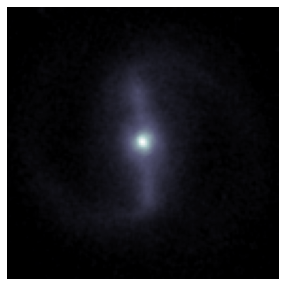

In [21]:
# for galaxies, psf, ps in cosmos:  # only way to take the first batch is to fake a for loop
#     break
plt.figure(figsize=(5, 5))
plt.imshow(np.log(galaxies[0, ..., 0] + 1e-1), cmap="bone")
plt.axis("off")
plt.savefig("talk_source1.png", bbox_inches="tight")

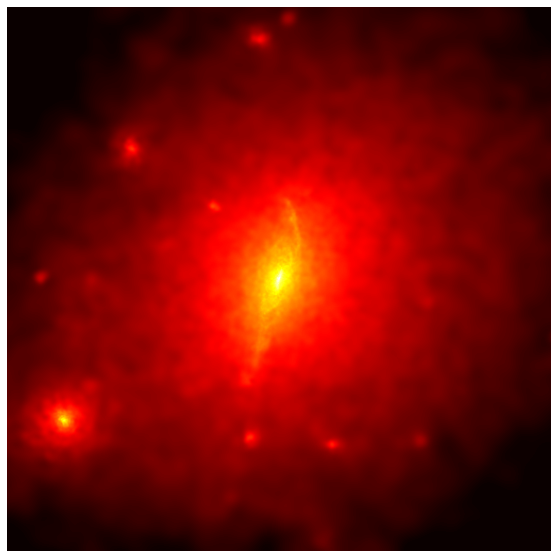

In [46]:
# kappa, einstein_radius, rescaling_factors, kappa_ids = kappa_gen.draw_batch(
#     1, rescale=True, shift=bool(max_shift), rotate=True, random_draw=True, return_einstein_radius_init=False)
plt.figure(figsize=(10, 10))
plt.imshow(kappa[0, ..., 0], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100))
plt.axis("off")
plt.savefig("talk_kappa1.png")

In [47]:
# batch_index = np.random.randint(0, n_galaxies//batch)
# for galaxies, psf, ps in cosmos.skip(batch_index):  # only way to take the first batch is to fake a for loop
#     break
galaxies = window[np.newaxis, ..., np.newaxis] * galaxies

# batch_size = galaxies.shape[0]
# kappa, einstein_radius, rescaling_factors, kappa_ids = kappa_gen.draw_batch(
#     batch_size, rescale=True, shift=bool(max_shift), rotate=True, random_draw=True, return_einstein_radius_init=False)

# lensed_images = phys.noisy_forward(galaxies, kappa*1.2, noise_rms=noise_rms)
lensed_images = phys.forward(galaxies, kappa)
lensed_images = tf.nn.relu(lensed_images)  # remove negative pixels
lensed_images /= tf.reduce_max(lensed_images, keepdims=True)
im_area = tf.reduce_sum(tf.cast(lensed_images>0.5, tf.float32), axis=(1, 2, 3)) * (image_fov/lensed_images.shape[1])**2
src_area = tf.reduce_sum(tf.cast(galaxies>0.5, tf.float32), axis=(1, 2, 3)) * (source_fov/galaxies.shape[1])**2
magnification = im_area / src_area

In [134]:
# batch_index = np.random.randint(0, n_galaxies//batch)
# for galaxies, psf, ps in cosmos.skip(batch_index):  # only way to take the first batch is to fake a for loop
#     break
# galaxies = window[np.newaxis, ..., np.newaxis] * galaxies

# batch_size = galaxies.shape[0]
# kappa, einstein_radius, rescaling_factors, kappa_ids, einstein_radius_init = kappa_gen.draw_batch(
#     batch_size, rescale=True, shift=bool(max_shift), rotate=True, random_draw=True, return_einstein_radius_init=True)

# lensed_images = []
# magnification = []
# for i in tqdm(range(batch)):
#     im, jacobian = phys.lens_source_and_compute_jacobian(galaxies[i][None, ...], kappa[i][None])
# #     lensed_images = tf.nn.relu(lensed_images)  # remove negative pixels
# #     lensed_images /= tf.reduce_max(lensed_images, keepdims=True)
#     lensed_images.append(im)
#     magnification.append(tf.linalg.det(jacobian)**(-1))

In [135]:
# mmean = [m.numpy().squeeze()[lensed_images[i].numpy().squeeze() > 0].mean()  for i, m in enumerate(magnification)]

In [115]:
# plt.figure(figsize=(16, 12))
# plt.imshow(lensed_images[0][ ..., 0], cmap="bone", vmin=0, vmax=1, alpha=0.7)
# plt.axis("off")
# # plt.imshow(galaxies[0][..., 0], cmap="bone")
# # plt.imshow(kappa[0][..., 0], cmap="hot",  norm=ImageNormalize(stretch=LogStretch()))
# # plt.colorbar()
# plt.savefig("talk_main_background.png", bbox_inches="tight")

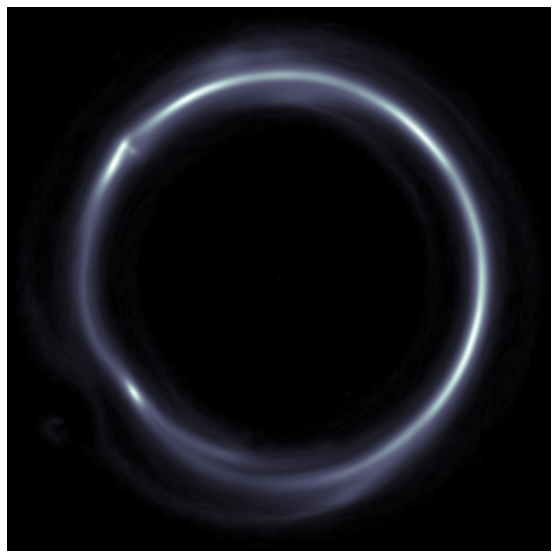

In [48]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log(lensed_images[0][ ..., 0] + 1e-1), cmap="bone")
plt.axis("off")
# plt.imshow(galaxies[0][..., 0], cmap="bone")
# plt.imshow(kappa[0][..., 0], cmap="hot",  norm=ImageNormalize(stretch=LogStretch()))
# plt.colorbar()
# plt.savefig("talk_reversed_main_background1.png", bbox_inches="tight")
plt.savefig("talk_lens1.png", bbox_inches="tight")

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
fig, axs = plt.subplots(10, 3, figsize=(15, 50))
for i in range(0, 10):
    axs[i, 0].imshow(kappa[i][..., 0], cmap="hot", norm=ImageNormalize(stretch=LogStretch()))
    axs[i, 1].imshow(galaxies[i][..., 0], cmap="bone")
    axs[i, 2].imshow(lensed_images[i][ ..., 0], cmap="bone", vmin=0, vmax=1)
    axs[i, 2].set_title(f"{magnification[i]:.2f}")
#     axs[i, 2].set_title(f"{lensed_images[i].numpy().sum():.2f}")
#     axs[i, 1].set_title(f"{galaxies[i].numpy().sum():.2f}")


#     im = axs[i, 3].imshow(magnification[i][0, ...], cmap="seismic", norm=SymLogNorm(linthresh=1e-1, base=10, vmax=100, vmin=-100))
#     divider = make_axes_locatable(axs[i, 3])
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     plt.colorbar(im, cax=cax)
#     axs[i, 3].axis("off")
    for j in range(3):
        axs[i, j].axis("off")        
# plt.subplots_adjust(wspace=0, hspace=0)

In [ ]:
    axs[i, 2].imshow(lensed_images[i][ ..., 0], cmap="bone", vmin=0, vmax=1)


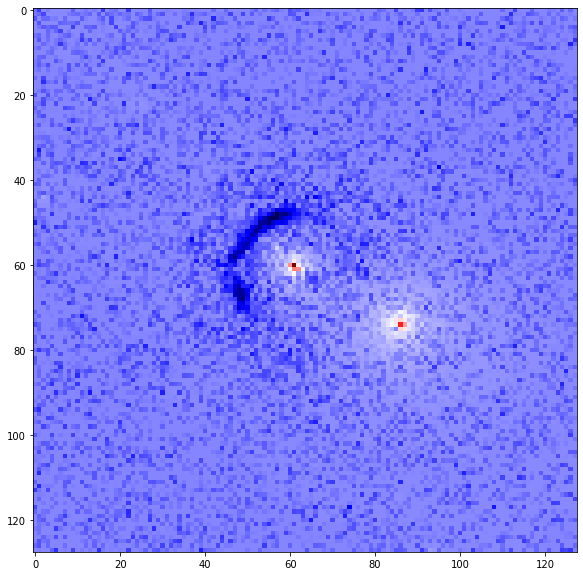

In [120]:
i = 5
plt.figure(figsize=(10, 10))
plt.imshow(kappa[i][..., 0] - 30*lensed_images[i][..., 0], cmap="seismic")